# Deep Q-learning for Cart-Pole

This notebook uses OpenAI Gym and Deep Q-learning to creating a playing agent for Cart-Pole. 

### Import dependencies and create a Cart-Pole playing environment

In [6]:
import gym
import tensorflow as tf
import numpy as np

In [7]:
env = gym.make('CartPole-v0')

### Explore the OpenAI Gym environment

Get a list of the possible actions for this game

In [3]:
env.action_space

Discrete(2)

There are two possible actions, moving the cart left and right--coded as 0 or 1 in the environment

---

Let's run a random simulation to see how the game it played

In [4]:
env.reset()
rewards = []
for move in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample())
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

In [5]:
env.close()

In [6]:
print(rewards)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The object of the game is to move the cart left or right to keep the pole from falling. The longer the pole stays up, the more reward we receive. For this game, we get a reward of 1 for each step that the pole is still standing.

### Building the Q-Network

In reinforcement learning we usually keep a matrix of all state-action pairs and update the values to help the agent learn. For some games, such as cart-pole, the number of state-action paris is simply too large for this to be feasible. Even for a simple game like cart-pole, there are four real-valued numbers that make up each possible state--position and velocity of the cart, and position and velocity of the pole. This creates a nearly infinite number of states.

In deep Q-learning, we use a neural network to approximate the Q-table. Our A-network takes a state as input and outputs q-values for each possible action. 

Our targets for training are $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$, thus we want to minimize $(\hat{Q}(s,a) - Q(s,a))^2$. This can be thought of as a measurement of how much reward can be expected in the next time step if we take a given action.

In [9]:
class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)

            # Target placeholder for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # Hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size)
            
            # Output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)
            
            # Trian on (targetQ - Q)^2
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### State Memory 
Reinforcement learning algorithms can have stability issues due to correlations between states. Thus, it's usually not a good idea to train in sequential states as the agent plays the game. Instead, we will let the agent play the game, store the experiences in memory, and then train the network on a random sample of past experiences.

In [10]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        index_list = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[index] for index in index_list]

### Exploration vs. Exploitation
In order for the agent to learn, it needs to explore its environmnet by taking random actions. As the agent learns, we want to take advantage of its exploration early on and choose what it thinks is the best action (exploit). At each step in the game we will decide whether the agent will explore or exploit. At the start of the game exploration will be more likely, but as the game progresses we will push the agent to exploit more.

### Training Algorithm
The network will be trained in *episodes*, which is the same as one simulation of the game. For Cart-Pole, the goal of an episode is to keep the pole upright for 195 frames. We start a new episode when meeting that goal or if the game ends because the pole tilts too far or the cart tries to move off the screen. This is how we'll train the agent.

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

### Hyperparameters

In [11]:
train_episodes = 1500          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 128               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [12]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

### Initialize Memory
Reset the simulation and populate the memory with a set of transitions to train on. 

In [13]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

for index in range(pretrain_length):
    # Uncomment to watch simulation
    # env.render()
    
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(state.shape)
        memory.add((state, action, reward, next_state))
        env.reset()
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        memory.add((state, action, reward, next_state))
        state = next_state

### Training

In [14]:
saver = tf.train.Saver()
rewards_list = []
loss = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    total_steps = 0
    for episode in range(1, train_episodes):
        total_reward = 0
        current_step = 0
        while current_step < max_steps:
            total_steps += 1
            
            # Determine whether to explore or exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*total_steps)
            if explore_p > np.random.rand():
                # Explore a random action
                action = env.action_space.sample()
            else:
                # Exploit best action
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
                
            # Execute action to get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                current_step = max_steps
                
                print('Episode: {}'.format(episode),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((episode, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take a random step to get the cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
                
            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                current_step += 1
                
            # Everything above is just to fill out the memory and let the agent play the game, this is where we actually train
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)
            
            loss, _ = sess.run([mainQN.loss, mainQN.optimizer],
                              feed_dict={mainQN.inputs_: states,
                                        mainQN.targetQs_: targets,
                                        mainQN.actions_: actions})
            
    saver.save(sess, "checkpoints/cartpole.ckpt")
    

Episode: 1 Total reward: 4.0 Training loss: 1.1756 Explore P: 0.9996
Episode: 2 Total reward: 13.0 Training loss: 1.1753 Explore P: 0.9983
Episode: 3 Total reward: 14.0 Training loss: 1.0523 Explore P: 0.9969
Episode: 4 Total reward: 20.0 Training loss: 1.0462 Explore P: 0.9950
Episode: 5 Total reward: 16.0 Training loss: 1.1859 Explore P: 0.9934
Episode: 6 Total reward: 14.0 Training loss: 1.1397 Explore P: 0.9920
Episode: 7 Total reward: 47.0 Training loss: 1.0715 Explore P: 0.9874
Episode: 8 Total reward: 26.0 Training loss: 1.3286 Explore P: 0.9849
Episode: 9 Total reward: 11.0 Training loss: 1.2614 Explore P: 0.9838
Episode: 10 Total reward: 14.0 Training loss: 1.3090 Explore P: 0.9824
Episode: 11 Total reward: 39.0 Training loss: 1.3295 Explore P: 0.9787
Episode: 12 Total reward: 23.0 Training loss: 1.5444 Explore P: 0.9764
Episode: 13 Total reward: 19.0 Training loss: 1.3815 Explore P: 0.9746
Episode: 14 Total reward: 32.0 Training loss: 1.5441 Explore P: 0.9715
Episode: 15 Tota

Episode: 117 Total reward: 24.0 Training loss: 119.8353 Explore P: 0.7896
Episode: 118 Total reward: 26.0 Training loss: 76.8118 Explore P: 0.7876
Episode: 119 Total reward: 17.0 Training loss: 79.7945 Explore P: 0.7863
Episode: 120 Total reward: 11.0 Training loss: 123.1683 Explore P: 0.7854
Episode: 121 Total reward: 21.0 Training loss: 178.7022 Explore P: 0.7838
Episode: 122 Total reward: 23.0 Training loss: 81.9697 Explore P: 0.7820
Episode: 123 Total reward: 11.0 Training loss: 127.7104 Explore P: 0.7812
Episode: 124 Total reward: 10.0 Training loss: 3.5623 Explore P: 0.7804
Episode: 125 Total reward: 20.0 Training loss: 3.0939 Explore P: 0.7789
Episode: 126 Total reward: 7.0 Training loss: 101.6192 Explore P: 0.7783
Episode: 127 Total reward: 15.0 Training loss: 276.9601 Explore P: 0.7772
Episode: 128 Total reward: 11.0 Training loss: 2.9213 Explore P: 0.7763
Episode: 129 Total reward: 20.0 Training loss: 70.7553 Explore P: 0.7748
Episode: 130 Total reward: 14.0 Training loss: 15

Episode: 238 Total reward: 13.0 Training loss: 0.9780 Explore P: 0.6251
Episode: 239 Total reward: 45.0 Training loss: 19.1864 Explore P: 0.6224
Episode: 240 Total reward: 23.0 Training loss: 20.5513 Explore P: 0.6209
Episode: 241 Total reward: 17.0 Training loss: 21.7457 Explore P: 0.6199
Episode: 242 Total reward: 17.0 Training loss: 16.3265 Explore P: 0.6189
Episode: 243 Total reward: 18.0 Training loss: 30.8824 Explore P: 0.6178
Episode: 244 Total reward: 18.0 Training loss: 14.7986 Explore P: 0.6167
Episode: 245 Total reward: 16.0 Training loss: 18.0239 Explore P: 0.6157
Episode: 246 Total reward: 42.0 Training loss: 1.4199 Explore P: 0.6132
Episode: 247 Total reward: 21.0 Training loss: 0.9784 Explore P: 0.6119
Episode: 248 Total reward: 63.0 Training loss: 1.2571 Explore P: 0.6081
Episode: 249 Total reward: 26.0 Training loss: 18.1063 Explore P: 0.6066
Episode: 250 Total reward: 14.0 Training loss: 24.2054 Explore P: 0.6057
Episode: 251 Total reward: 24.0 Training loss: 34.1749 

Episode: 351 Total reward: 105.0 Training loss: 2.1272 Explore P: 0.3719
Episode: 352 Total reward: 79.0 Training loss: 75.6897 Explore P: 0.3691
Episode: 353 Total reward: 93.0 Training loss: 84.0930 Explore P: 0.3657
Episode: 354 Total reward: 112.0 Training loss: 42.4233 Explore P: 0.3618
Episode: 355 Total reward: 138.0 Training loss: 38.0009 Explore P: 0.3570
Episode: 356 Total reward: 199.0 Training loss: 42.0065 Explore P: 0.3501
Episode: 357 Total reward: 163.0 Training loss: 1.7738 Explore P: 0.3446
Episode: 358 Total reward: 81.0 Training loss: 140.9275 Explore P: 0.3419
Episode: 359 Total reward: 157.0 Training loss: 2.7810 Explore P: 0.3368
Episode: 360 Total reward: 73.0 Training loss: 6.3305 Explore P: 0.3344
Episode: 361 Total reward: 60.0 Training loss: 72.9790 Explore P: 0.3324
Episode: 362 Total reward: 118.0 Training loss: 2.2914 Explore P: 0.3287
Episode: 363 Total reward: 199.0 Training loss: 4.6469 Explore P: 0.3224
Episode: 364 Total reward: 199.0 Training loss: 

Episode: 464 Total reward: 199.0 Training loss: 0.3676 Explore P: 0.0671
Episode: 465 Total reward: 199.0 Training loss: 0.3111 Explore P: 0.0660
Episode: 466 Total reward: 199.0 Training loss: 315.3241 Explore P: 0.0649
Episode: 467 Total reward: 199.0 Training loss: 0.5417 Explore P: 0.0638
Episode: 468 Total reward: 199.0 Training loss: 0.2517 Explore P: 0.0628
Episode: 469 Total reward: 199.0 Training loss: 0.4428 Explore P: 0.0617
Episode: 470 Total reward: 199.0 Training loss: 0.6560 Explore P: 0.0607
Episode: 471 Total reward: 199.0 Training loss: 0.1914 Explore P: 0.0597
Episode: 472 Total reward: 199.0 Training loss: 266.7272 Explore P: 0.0587
Episode: 473 Total reward: 199.0 Training loss: 0.2310 Explore P: 0.0578
Episode: 474 Total reward: 199.0 Training loss: 229.7998 Explore P: 0.0568
Episode: 475 Total reward: 199.0 Training loss: 285.0441 Explore P: 0.0559
Episode: 476 Total reward: 199.0 Training loss: 0.2414 Explore P: 0.0550
Episode: 477 Total reward: 199.0 Training l

Episode: 578 Total reward: 72.0 Training loss: 0.6169 Explore P: 0.0172
Episode: 579 Total reward: 199.0 Training loss: 0.3492 Explore P: 0.0170
Episode: 580 Total reward: 84.0 Training loss: 0.3777 Explore P: 0.0170
Episode: 581 Total reward: 76.0 Training loss: 84.2530 Explore P: 0.0169
Episode: 582 Total reward: 95.0 Training loss: 0.5778 Explore P: 0.0169
Episode: 583 Total reward: 199.0 Training loss: 0.2978 Explore P: 0.0167
Episode: 584 Total reward: 63.0 Training loss: 0.1074 Explore P: 0.0167
Episode: 585 Total reward: 88.0 Training loss: 0.3942 Explore P: 0.0166
Episode: 586 Total reward: 199.0 Training loss: 0.2634 Explore P: 0.0165
Episode: 587 Total reward: 125.0 Training loss: 0.2356 Explore P: 0.0164
Episode: 588 Total reward: 199.0 Training loss: 0.1060 Explore P: 0.0163
Episode: 589 Total reward: 54.0 Training loss: 0.2123 Explore P: 0.0163
Episode: 590 Total reward: 61.0 Training loss: 0.1699 Explore P: 0.0162
Episode: 591 Total reward: 199.0 Training loss: 0.4668 Exp

Episode: 691 Total reward: 199.0 Training loss: 0.2153 Explore P: 0.0109
Episode: 692 Total reward: 199.0 Training loss: 0.5129 Explore P: 0.0109
Episode: 693 Total reward: 199.0 Training loss: 0.2925 Explore P: 0.0109
Episode: 694 Total reward: 199.0 Training loss: 0.4260 Explore P: 0.0108
Episode: 695 Total reward: 199.0 Training loss: 0.3335 Explore P: 0.0108
Episode: 696 Total reward: 199.0 Training loss: 0.4102 Explore P: 0.0108
Episode: 697 Total reward: 199.0 Training loss: 0.2342 Explore P: 0.0108
Episode: 698 Total reward: 199.0 Training loss: 0.2981 Explore P: 0.0108
Episode: 699 Total reward: 199.0 Training loss: 0.3775 Explore P: 0.0108
Episode: 700 Total reward: 199.0 Training loss: 0.1577 Explore P: 0.0107
Episode: 701 Total reward: 199.0 Training loss: 0.4164 Explore P: 0.0107
Episode: 702 Total reward: 199.0 Training loss: 0.1895 Explore P: 0.0107
Episode: 703 Total reward: 199.0 Training loss: 0.3284 Explore P: 0.0107
Episode: 704 Total reward: 199.0 Training loss: 0.1

Episode: 804 Total reward: 199.0 Training loss: 0.1456 Explore P: 0.0101
Episode: 805 Total reward: 199.0 Training loss: 0.1803 Explore P: 0.0101
Episode: 806 Total reward: 199.0 Training loss: 200.8581 Explore P: 0.0101
Episode: 807 Total reward: 199.0 Training loss: 0.1792 Explore P: 0.0101
Episode: 808 Total reward: 199.0 Training loss: 0.3391 Explore P: 0.0101
Episode: 809 Total reward: 199.0 Training loss: 0.4329 Explore P: 0.0101
Episode: 810 Total reward: 199.0 Training loss: 0.0870 Explore P: 0.0101
Episode: 811 Total reward: 199.0 Training loss: 0.1443 Explore P: 0.0101
Episode: 812 Total reward: 199.0 Training loss: 0.1685 Explore P: 0.0101
Episode: 813 Total reward: 199.0 Training loss: 0.1582 Explore P: 0.0101
Episode: 814 Total reward: 199.0 Training loss: 0.2634 Explore P: 0.0101
Episode: 815 Total reward: 199.0 Training loss: 0.1814 Explore P: 0.0101
Episode: 816 Total reward: 199.0 Training loss: 0.2449 Explore P: 0.0101
Episode: 817 Total reward: 199.0 Training loss: 0

Episode: 917 Total reward: 199.0 Training loss: 0.1109 Explore P: 0.0100
Episode: 918 Total reward: 199.0 Training loss: 0.1198 Explore P: 0.0100
Episode: 919 Total reward: 199.0 Training loss: 0.0885 Explore P: 0.0100
Episode: 920 Total reward: 199.0 Training loss: 0.1392 Explore P: 0.0100
Episode: 921 Total reward: 199.0 Training loss: 0.1546 Explore P: 0.0100
Episode: 922 Total reward: 199.0 Training loss: 0.0953 Explore P: 0.0100
Episode: 923 Total reward: 199.0 Training loss: 0.1760 Explore P: 0.0100
Episode: 924 Total reward: 199.0 Training loss: 0.2316 Explore P: 0.0100
Episode: 925 Total reward: 199.0 Training loss: 0.1424 Explore P: 0.0100
Episode: 926 Total reward: 199.0 Training loss: 0.0719 Explore P: 0.0100
Episode: 927 Total reward: 199.0 Training loss: 0.2688 Explore P: 0.0100
Episode: 928 Total reward: 199.0 Training loss: 0.0978 Explore P: 0.0100
Episode: 929 Total reward: 199.0 Training loss: 0.1860 Explore P: 0.0100
Episode: 930 Total reward: 199.0 Training loss: 0.1

Episode: 1029 Total reward: 199.0 Training loss: 0.2787 Explore P: 0.0100
Episode: 1030 Total reward: 199.0 Training loss: 0.2215 Explore P: 0.0100
Episode: 1031 Total reward: 199.0 Training loss: 0.3167 Explore P: 0.0100
Episode: 1032 Total reward: 199.0 Training loss: 0.3060 Explore P: 0.0100
Episode: 1033 Total reward: 165.0 Training loss: 0.7163 Explore P: 0.0100
Episode: 1034 Total reward: 199.0 Training loss: 279.0655 Explore P: 0.0100
Episode: 1035 Total reward: 199.0 Training loss: 0.2836 Explore P: 0.0100
Episode: 1036 Total reward: 199.0 Training loss: 150.7680 Explore P: 0.0100
Episode: 1037 Total reward: 199.0 Training loss: 0.4395 Explore P: 0.0100
Episode: 1038 Total reward: 199.0 Training loss: 0.5257 Explore P: 0.0100
Episode: 1039 Total reward: 199.0 Training loss: 0.5138 Explore P: 0.0100
Episode: 1040 Total reward: 199.0 Training loss: 0.4526 Explore P: 0.0100
Episode: 1041 Total reward: 199.0 Training loss: 0.2019 Explore P: 0.0100
Episode: 1042 Total reward: 199.0 

Episode: 1148 Total reward: 12.0 Training loss: 29.3328 Explore P: 0.0100
Episode: 1149 Total reward: 8.0 Training loss: 2511.5962 Explore P: 0.0100
Episode: 1150 Total reward: 8.0 Training loss: 35.2401 Explore P: 0.0100
Episode: 1151 Total reward: 8.0 Training loss: 3644.5801 Explore P: 0.0100
Episode: 1152 Total reward: 10.0 Training loss: 26.5424 Explore P: 0.0100
Episode: 1153 Total reward: 8.0 Training loss: 41.1830 Explore P: 0.0100
Episode: 1154 Total reward: 9.0 Training loss: 35.6842 Explore P: 0.0100
Episode: 1155 Total reward: 8.0 Training loss: 25.6014 Explore P: 0.0100
Episode: 1156 Total reward: 11.0 Training loss: 14.1915 Explore P: 0.0100
Episode: 1157 Total reward: 9.0 Training loss: 11.1316 Explore P: 0.0100
Episode: 1158 Total reward: 10.0 Training loss: 7352.8975 Explore P: 0.0100
Episode: 1159 Total reward: 10.0 Training loss: 3767.0461 Explore P: 0.0100
Episode: 1160 Total reward: 9.0 Training loss: 5.2918 Explore P: 0.0100
Episode: 1161 Total reward: 9.0 Trainin

Episode: 1260 Total reward: 199.0 Training loss: 1.2059 Explore P: 0.0100
Episode: 1261 Total reward: 199.0 Training loss: 1.0040 Explore P: 0.0100
Episode: 1262 Total reward: 199.0 Training loss: 0.7826 Explore P: 0.0100
Episode: 1263 Total reward: 199.0 Training loss: 3.9103 Explore P: 0.0100
Episode: 1264 Total reward: 199.0 Training loss: 2.1098 Explore P: 0.0100
Episode: 1265 Total reward: 199.0 Training loss: 4.0350 Explore P: 0.0100
Episode: 1266 Total reward: 199.0 Training loss: 173.4200 Explore P: 0.0100
Episode: 1267 Total reward: 199.0 Training loss: 1.2779 Explore P: 0.0100
Episode: 1268 Total reward: 199.0 Training loss: 1.0412 Explore P: 0.0100
Episode: 1269 Total reward: 199.0 Training loss: 0.9413 Explore P: 0.0100
Episode: 1270 Total reward: 199.0 Training loss: 0.7040 Explore P: 0.0100
Episode: 1271 Total reward: 199.0 Training loss: 1.4544 Explore P: 0.0100
Episode: 1272 Total reward: 199.0 Training loss: 0.6997 Explore P: 0.0100
Episode: 1273 Total reward: 199.0 Tr

Episode: 1371 Total reward: 199.0 Training loss: 0.0929 Explore P: 0.0100
Episode: 1372 Total reward: 199.0 Training loss: 101.8636 Explore P: 0.0100
Episode: 1373 Total reward: 199.0 Training loss: 0.1554 Explore P: 0.0100
Episode: 1374 Total reward: 199.0 Training loss: 0.0809 Explore P: 0.0100
Episode: 1375 Total reward: 199.0 Training loss: 0.0831 Explore P: 0.0100
Episode: 1376 Total reward: 199.0 Training loss: 0.1179 Explore P: 0.0100
Episode: 1377 Total reward: 199.0 Training loss: 0.1106 Explore P: 0.0100
Episode: 1378 Total reward: 199.0 Training loss: 0.1849 Explore P: 0.0100
Episode: 1379 Total reward: 199.0 Training loss: 0.0290 Explore P: 0.0100
Episode: 1380 Total reward: 199.0 Training loss: 0.0200 Explore P: 0.0100
Episode: 1381 Total reward: 199.0 Training loss: 0.0934 Explore P: 0.0100
Episode: 1382 Total reward: 199.0 Training loss: 0.0805 Explore P: 0.0100
Episode: 1383 Total reward: 199.0 Training loss: 0.1906 Explore P: 0.0100
Episode: 1384 Total reward: 199.0 Tr

Episode: 1482 Total reward: 199.0 Training loss: 0.1756 Explore P: 0.0100
Episode: 1483 Total reward: 199.0 Training loss: 0.0995 Explore P: 0.0100
Episode: 1484 Total reward: 199.0 Training loss: 0.0378 Explore P: 0.0100
Episode: 1485 Total reward: 199.0 Training loss: 0.1935 Explore P: 0.0100
Episode: 1486 Total reward: 199.0 Training loss: 0.0845 Explore P: 0.0100
Episode: 1487 Total reward: 199.0 Training loss: 0.1346 Explore P: 0.0100
Episode: 1488 Total reward: 199.0 Training loss: 90.2376 Explore P: 0.0100
Episode: 1489 Total reward: 199.0 Training loss: 0.0648 Explore P: 0.0100
Episode: 1490 Total reward: 199.0 Training loss: 0.1960 Explore P: 0.0100
Episode: 1491 Total reward: 199.0 Training loss: 0.2953 Explore P: 0.0100
Episode: 1492 Total reward: 199.0 Training loss: 0.1383 Explore P: 0.0100
Episode: 1493 Total reward: 199.0 Training loss: 0.1005 Explore P: 0.0100
Episode: 1494 Total reward: 199.0 Training loss: 0.1874 Explore P: 0.0100
Episode: 1495 Total reward: 199.0 Tra

### Visualizing the training progress
Gray line is the total reward for each episode and blue is the running mean

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

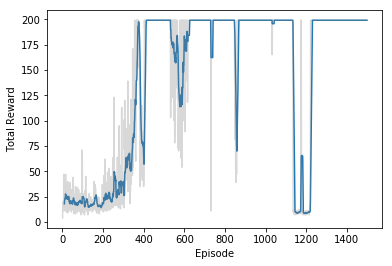

In [16]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

### Testing
We can watch our trained model play Cart-Pole!

In [17]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for episode in range(1, test_episodes):
        current_step = 0
        while current_step < test_max_steps:
            env.render()
            
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            next_state, reward, done, _ = env.step(action)
            
            if done:
                current_step = test_max_steps
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                current_step += 1
                

In [18]:
env.close()